We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [3]:
from keras.layers import Input, Dense
from keras.layers import BatchNormalization
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Let's also create a separate encoder model:

In [4]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

As well as the decoder model:

In [5]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [6]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [7]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [8]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Now let's train our autoencoder for 50 epochs:

In [15]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s - loss: 0.6289 - val_loss: 0.5660
Epoch 2/20
60000/60000 [==============================] - 3s - loss: 0.5169 - val_loss: 0.4750
Epoch 3/20
60000/60000 [==============================] - 3s - loss: 0.4446 - val_loss: 0.4189
Epoch 4/20
60000/60000 [==============================] - 3s - loss: 0.3996 - val_loss: 0.3832
Epoch 5/20
60000/60000 [==============================] - 3s - loss: 0.3703 - val_loss: 0.3591
Epoch 6/20
60000/60000 [==============================] - 3s - loss: 0.3500 - val_loss: 0.3422
Epoch 7/20
60000/60000 [==============================] - 3s - loss: 0.3355 - val_loss: 0.3297
Epoch 8/20
60000/60000 [==============================] - 3s - loss: 0.3247 - val_loss: 0.3203
Epoch 9/20
60000/60000 [==============================] - 3s - loss: 0.3164 - val_loss: 0.3130
Epoch 10/20
60000/60000 [==============================] - 3s - loss: 0.3099 - val_loss: 0.3072

After 20 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.096. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

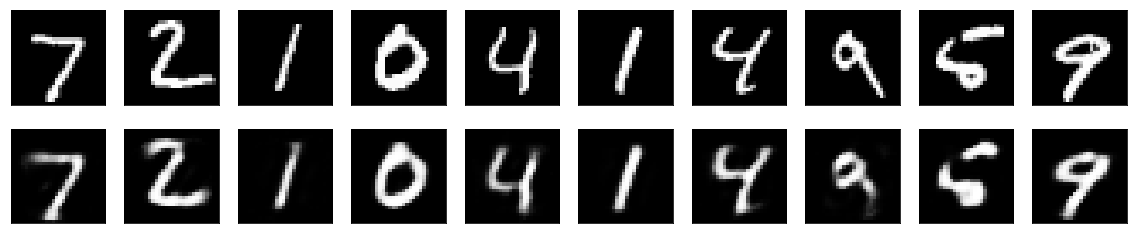

In [9]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Adding a sparsity constraint on the encoded representations

In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:

In [10]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

They look pretty similar to the previous model, the only significant difference being the sparsity of the encoded representations. encoded_imgs.mean() yields a value 3.33 (over our 10,000 test images), whereas with the previous model the same quantity was 7.30. So our new model yields encoded representations that are twice sparser.

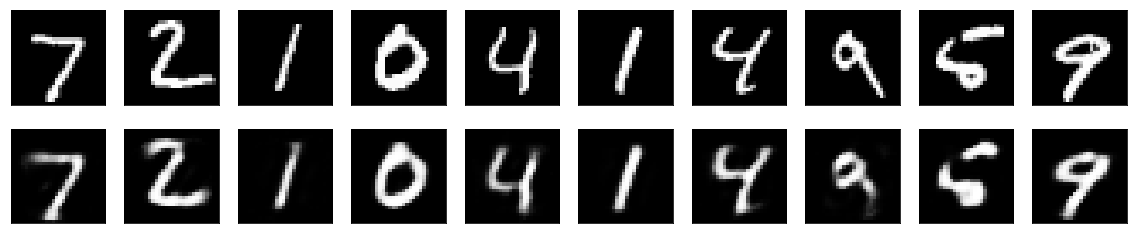

In [16]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Deep autoencoder

We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:

In [17]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

Let's try this:

In [18]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s - loss: 0.2767 - val_loss: 0.2261
Epoch 2/50
60000/60000 [==============================] - 5s - loss: 0.2010 - val_loss: 0.1783
Epoch 3/50
60000/60000 [==============================] - 5s - loss: 0.1677 - val_loss: 0.1582
Epoch 4/50
60000/60000 [==============================] - 5s - loss: 0.1532 - val_loss: 0.1458
Epoch 5/50
60000/60000 [==============================] - 4s - loss: 0.1442 - val_loss: 0.1384
Epoch 6/50
60000/60000 [==============================] - 4s - loss: 0.1358 - val_loss: 0.1295
Epoch 7/50
60000/60000 [==============================] - 4s - loss: 0.1287 - val_loss: 0.1245
Epoch 8/50
60000/60000 [==============================] - 4s - loss: 0.1248 - val_loss: 0.1222
Epoch 9/50
60000/60000 [==============================] - 5s - loss: 0.1216 - val_loss: 0.1182
Epoch 10/50
60000/60000 [==============================] - 4s - loss: 0.1186 - val_loss: 0.1152

After 100 epochs, it reaches a train and test loss of ~0.0915, a bit better than our previous models. Our reconstructed digits look a bit better too:

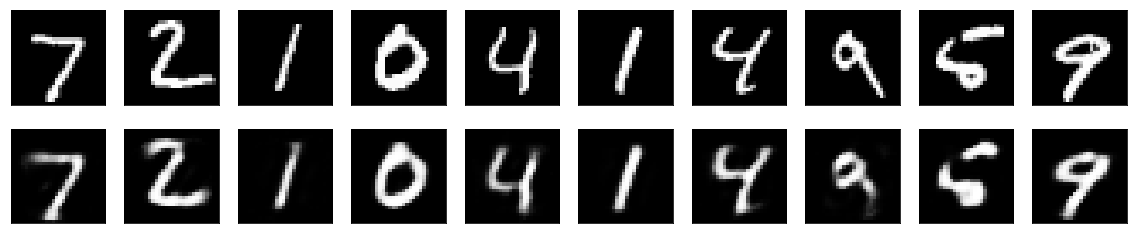

In [19]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Convolutional autoencoder

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [9]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [10]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [11]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 24s - loss: 0.2464 - val_loss: 0.1475
Epoch 2/20
60000/60000 [==============================] - 21s - loss: 0.1346 - val_loss: 0.1254s: 0. - ETA: 1s - lo - ETA: 1
Epoch 3/20
60000/60000 [==============================] - 21s - loss: 0.1219 - val_loss: 0.1176
Epoch 4/20
60000/60000 [==============================] - 21s - loss: 0.1157 - val_loss: 0.1126
Epoch 5/20
60000/60000 [==============================] - 22s - loss: 0.1116 - val_loss: 0.1085
Epoch 6/20
60000/60000 [==============================] - 21s - loss: 0.1087 - val_loss: 0.1071
Epoch 7/20
60000/60000 [==============================] - 21s - loss: 0.1065 - val_loss: 0.1051
Epoch 8/20
60000/60000 [==============================] - 21s - loss: 0.1047 - val_loss: 0.1019
Epoch 9/20
60000/60000 [==============================] - 24s - loss: 0.1033 - val_loss: 0.1030
Epoch 10/20
60000/60000 [==============================] 

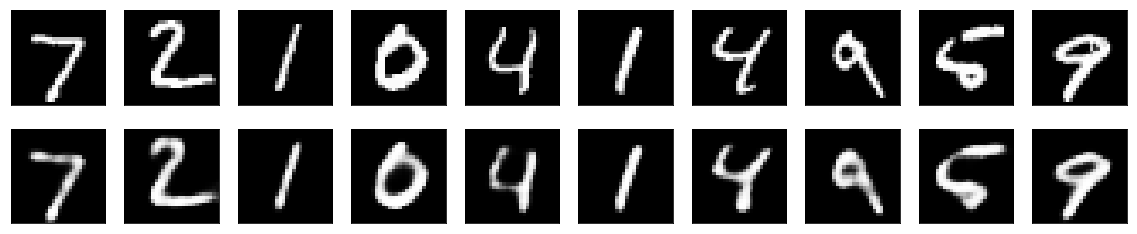

In [13]:
decoded_imgs = autoencoder.predict(x_test)
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

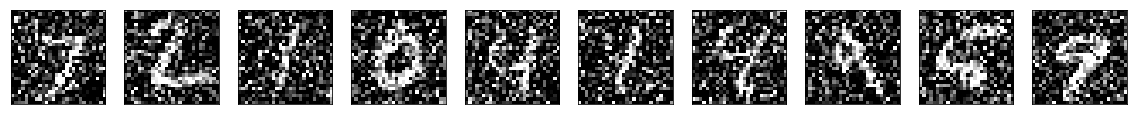

In [15]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 22s - loss: 0.1362 - val_loss: 0.1298
Epoch 2/10
60000/60000 [==============================] - 26s - loss: 0.1288 - val_loss: 0.1261
Epoch 3/10
60000/60000 [==============================] - 26s - loss: 0.1267 - val_loss: 0.1256
Epoch 4/10
60000/60000 [==============================] - 26s - loss: 0.1255 - val_loss: 0.1234
Epoch 5/10
60000/60000 [==============================] - 26s - loss: 0.1244 - val_loss: 0.1231
Epoch 6/10
60000/60000 [==============================] - 27s - loss: 0.1236 - val_loss: 0.1223
Epoch 7/10
60000/60000 [==============================] - 26s - loss: 0.1231 - val_loss: 0.1215
Epoch 8/10
60000/60000 [==============================] - 26s - loss: 0.1226 - val_loss: 0.1223
Epoch 9/10
60000/60000 [==============================] - 27s - loss: 0.1222 - val_loss: 0.1213
Epoch 10/10
60000/60000 [==============================] - 29s - loss: 0.1218 - val_lo

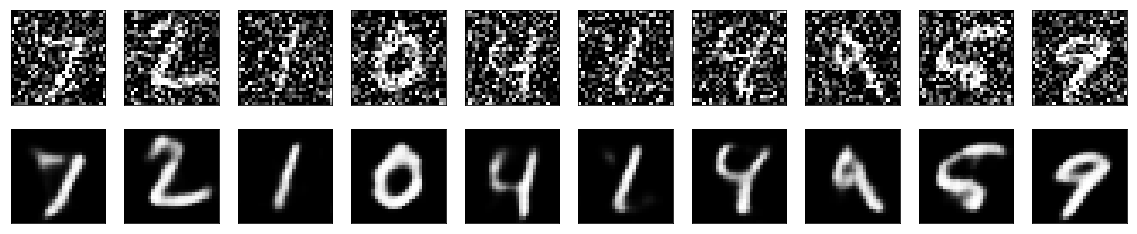

In [17]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()